In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import cm

In [3]:
yelp = pd.read_csv('Python-Yelp-Final-Project/yelp_academic_dataset_business.csv',
                   usecols = ["categories","city","latitude","longitude","name","review_count","stars","state"])

In [4]:
yelp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 188593 entries, 0 to 188592
Data columns (total 8 columns):
categories      188052 non-null object
city            188583 non-null object
latitude        188587 non-null float64
longitude       188587 non-null float64
name            188593 non-null object
review_count    188593 non-null int64
stars           188593 non-null float64
state           188593 non-null object
dtypes: float64(3), int64(1), object(4)
memory usage: 11.5+ MB


# Split Category data and make data set long
this will allow us to determine average star ratings for individual category elements. [Note: while discussing my code in the peer review, this section was liked so much by my peers that many of them talked about trying to implement this style of solution in their code! I would say because of that the way I handled categories was the strongest part of my code.]


In [5]:
#split categories up into separate columns instead of comma separated all in the same column
yelp2 = pd.concat([yelp,yelp.categories.str.split(',',expand=True)],1)
#drop old categories column
yelp2 = yelp2.drop(['categories'],axis = 1)
#take wide data and make it long by grouping category columns to one 
yelp_long = pd.melt(yelp2,id_vars = ["city","latitude","longitude","name","review_count","stars","state"],value_name = 'category')
# get rid of businesses with less than the median review count to avoid skewed results
print("Median review count for individual businesses:",yelp_long.review_count.median())
review_mask = yelp_long.review_count>yelp_long.review_count.median()
yelp_long = yelp_long[review_mask]
#get rid of variable column
yelp_long = yelp_long.drop(['variable'],axis = 1)
#strip white spaces from category column
yelp_long.category = yelp_long.category.str.strip()

Median review count for individual businesses: 9.0


In [20]:
yelp2.head()

,city,latitude,longitude,name,review_count,stars,state,0,1,2,...,27,28,29,30,31,32,33,34,35,36
0,Calgary,51.091813,-114.031675,Minhas Micro Brewery,24,4.0,AB,Tours,Breweries,Pizza,...,None,None,None,None,None,None,None,None,None,None
1,Henderson,35.960734,-114.939821,CK'S BBQ & Catering,3,4.5,NV,Chicken Wings,Burgers,Caterers,...,None,None,None,None,None,None,None,None,None,None
2,Montréal,45.540503,-73.599300,La Bastringue,5,4.0,QC,Breakfast & Brunch,Restaurants,French,...,None,None,None,None,None,None,None,None,None,None
3,Phoenix,33.449999,-112.076979,Geico Insurance,8,1.5,AZ,Insurance,Financial Services,None,...,None,None,None,None,None,None,None,None,None,None
4,Calgary,51.035591,-114.027366,Action Engine,4,2.0,AB,Home & Garden,Nurseries & Gardening,Shopping,...,None,None,None,None,None,None,None,None,None,None


# Reduce Data Set Size
Now that the data is in the long form notice that we still have many rows that are unnecessary and have None in them as an artifact from the way the category data was split out to columns. 226 MB is a large dataset! This data will be reduced by ~10x down to 22 MB just by removing rows with null values in the category column and will improve computational efficiency of the code.

In [6]:
yelp_long.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3294517 entries, 0 to 6977939
Data columns (total 8 columns):
city            object
latitude        float64
longitude       float64
name            object
review_count    int64
stars           float64
state           object
category        object
dtypes: float64(3), int64(1), object(4)
memory usage: 226.2+ MB


In [7]:
#remove categories that are blank from the str split function earlier
yelp_long = yelp_long[pd.notnull(yelp_long.category)]
yelp_long.index = range(len(yelp_long))

In [8]:
yelp_long.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 371156 entries, 0 to 371155
Data columns (total 8 columns):
city            371143 non-null object
latitude        371141 non-null float64
longitude       371141 non-null float64
name            371156 non-null object
review_count    371156 non-null int64
stars           371156 non-null float64
state           371156 non-null object
category        371156 non-null object
dtypes: float64(3), int64(1), object(4)
memory usage: 22.7+ MB


# Group by City and aggregate stars and reviews
The group by city will allow us to determine average star rating by city to find the easiest cities for ratings which will allow our business to get great yelp reviews. Keeping the review counts will allow us to pick a bigger city out of the easiest cities so the potential customer base will be high which is better for the business to be successful

In [9]:
#Find Eligible Cities to put a new business in by grouping by city and summarizing stars and review counts
yelp_long_cities = yelp_long.groupby('city').agg({'stars':np.mean,'review_count':np.sum})
print("Average review counts in each city:",round(yelp_long_cities.review_count.mean()))
# select only cities that have above the average number of reviews to avoid cities that may have skewed 
# data by only having a few reviews 
big_city_mask = yelp_long_cities.review_count > yelp_long_cities.review_count.mean()
yelp_long_big_cities = yelp_long_cities[big_city_mask].sort_values('stars',ascending = False)[0:7]


Average review counts in each city: 38262


([0, 1, 2, 3, 4, 5, 6], <a list of 7 Text xticklabel objects>)

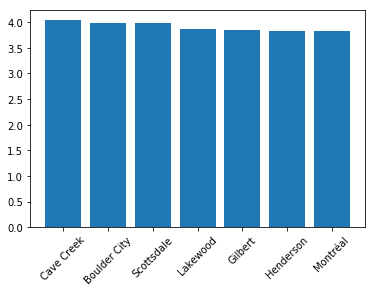

In [10]:
# plot out average stars from bigger cities to find the easiest cities to get high star ratings in
fig, axes = plt.subplots()
axes.bar(x=yelp_long_big_cities.index,height = yelp_long_big_cities.stars)
plt.xticks(rotation=45)

In [11]:
most_reviews_remaining=yelp_long_big_cities.sort_values('review_count',ascending = False)
most_reviews_remaining

,stars,review_count
city,,
Scottsdale,3.984358,1674397
Henderson,3.830236,852319
Montréal,3.826671,488137
Gilbert,3.844148,482664
Lakewood,3.858005,73893
Cave Creek,4.037923,50382
Boulder City,3.986056,38508


([0, 1, 2, 3, 4, 5, 6], <a list of 7 Text xticklabel objects>)

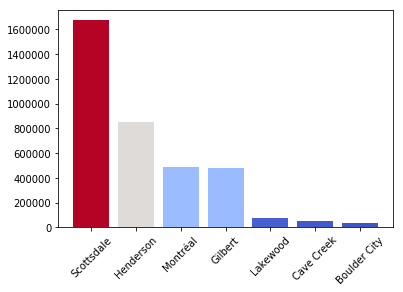

In [12]:
# plot out total reviews from top cities to find biggest yelp market

colors = cm.coolwarm(most_reviews_remaining.review_count / float(max(most_reviews_remaining.review_count)))
fig, axes = plt.subplots()
axes.bar(x=most_reviews_remaining.index,height = most_reviews_remaining.review_count,color=colors)
plt.xticks(rotation=45)

# City Decision : Scottsdale
Based on the two graphs we can see that sorting for average ratings for cities and picking the top cities then sorting by review counts Scottsdale seems like the obvious choice for a city to start a new business in. Next we will determine what the best type of business to start in Scottsdale would be.

In [13]:
# Determine what businesses are best in 
easy_city_mask = yelp_long.city.isin(yelp_long_big_cities.index.tolist())
yelp_long_easy_cities = yelp_long[easy_city_mask]

In [17]:
scottsdale_mask = yelp_long.city.isin(['Scottsdale'])
scottsdale_businesses = yelp_long[scottsdale_mask].groupby('category').agg({'stars':np.mean,'review_count':np.sum})

In [15]:
#Find the Categories that are lowest rated in these easier cities
yelp_long_easy_cities_grouped_category = yelp_long_easy_cities.groupby('category').agg({'stars':np.mean,'review_count':np.sum})
print("Average review counts in each category of cities:",round(yelp_long_easy_cities_grouped_category.review_count.mean()))


Average review counts in each category of cities: 3550


In [18]:
#Find the General averages for all categories and associated total reviews
yelp_long_categories = yelp_long.groupby('category').aggregate({'stars':np.mean,'review_count':np.sum})
yelp_long_categories.columns = ['Overall_Average_Stars','Overall_Total_Reviews']
#Join these averages with the averages from easy cities in a new dataframe
yelp_long_adjusted_stars = yelp_long_categories.join(scottsdale_businesses)
#Get rid of categories with low total reviews because they will not be statistically significant data
review_mask = yelp_long_adjusted_stars.Overall_Total_Reviews > 150
yelp_long_adjusted_stars = yelp_long_adjusted_stars[review_mask]
# Now see what businesses categories average high star ratings but arent in these easy rating cities
business_ideas = yelp_long_adjusted_stars[yelp_long_adjusted_stars.stars.isna()].sort_values('Overall_Average_Stars',ascending = False)
best_business_ideas = business_ideas[0:5]
best_business_ideas

,Overall_Average_Stars,Overall_Total_Reviews,stars,review_count
category,,,,
Brazilian Jiu-jitsu,4.947368,418,NaN,NaN
Self-defense Classes,4.884615,792,NaN,NaN
Hot Air Balloons,4.857143,831,NaN,NaN
Mobile Dent Repair,4.826087,1465,NaN,NaN
First Aid Classes,4.812500,488,NaN,NaN


([0, 1, 2, 3, 4], <a list of 5 Text xticklabel objects>)

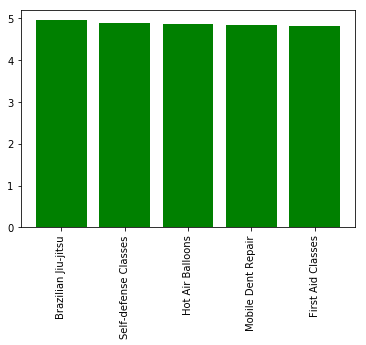

In [19]:
# plot out average stars from bigger cities to find the easiest cities to get high star ratings in
fig, axes = plt.subplots()
axes.bar(x=best_business_ideas.index,height = best_business_ideas.Overall_Average_Stars,color='green')
plt.xticks(rotation=90)

# Business Decision: Brazilian Jiu-Jitsu/Self-defense Classes

By selecting highly rated business categories that are not already in Scottsdale we are able to see the list of good business opportunities that have not been opened in Scottsdale yet. This strategy works in our case because the results are not location related businesses. If we got results that needed natural resources like a lake, ski slope or beach we would need to ignore those and move to the first location agnostic idea.